#A/B Testing and Player Retention in Mobile Games🤖

##Background


Cookie Cats is a hugely popular mobile puzzle game developed by Tactile Entertainment. It's a classic "connect three" style puzzle game where the player must connect tiles of the same color in order to clear the board and win the level. It also features singing cats. 

As players progress through the game they will encounter gates that force them to wait some time before they can progress or make an in-app purchase. In this project, we will analyze the result of an A/B test where the first gate in Cookie Cats was moved from level 30 to level 40. In particular, I will analyze the impact on player retention and game rounds.


The data is from 90,189 players that installed the game while the AB-test was running. The variables are:


*   userid - a unique number that identifies each player.
*   version - whether the player was put in the control group (gate_30 - a gate at level 30) or the test group (gate_40 - a gate at level 40).
*   sum_gamerounds - the number of game rounds played by the player during the first week after installation
*   retention_1 - did the player come back and play 1 day after installing?
*   retention_7 - did the player come back and play 7 days after installing?


When a player installed the game, he or she was randomly assigned to either gate_30 or gate_40.

###Importing Libraries

In [3]:
import statistics
import pandas as pd
from scipy.stats import shapiro
import scipy.stats as stats
from scipy.stats import mannwhitneyu
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)
from termcolor import colored

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.4f}'.format

###Loading the Dataset

In [4]:
df = pd.read_csv('/content/cookie_cats.csv')

###Data Exploration

In [5]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [7]:
df_total = df.isnull().sum()
df_total [:]

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

The data I use does not have missing values.

###Handling Outliers

Summary Statistics and Visualization

Summary Statistics by Version for sum_gamerounds 

sum_gamerounds
version    gate_30    gate_40
count   44700.0000 45489.0000
mean       52.4563    51.2988
std       256.7164   103.2944
median     17.0000    16.0000
min         0.0000     0.0000
max     49854.0000  2640.0000 

Histogram by Version for sum_gamerounds 



<ipython-input-8-b4223e1bab1c>:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df[(df.version == "gate_30")][x] , color="skyblue", label="Gate30")
<ipython-input-8-b4223e1bab1c>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df[(df.version == "gate_40")][x] , color="red", label="Gate40")


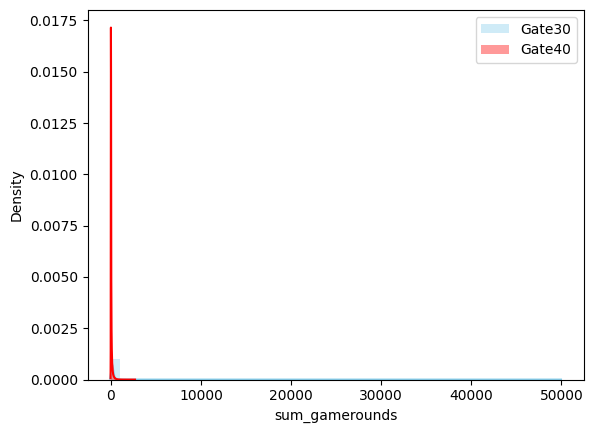

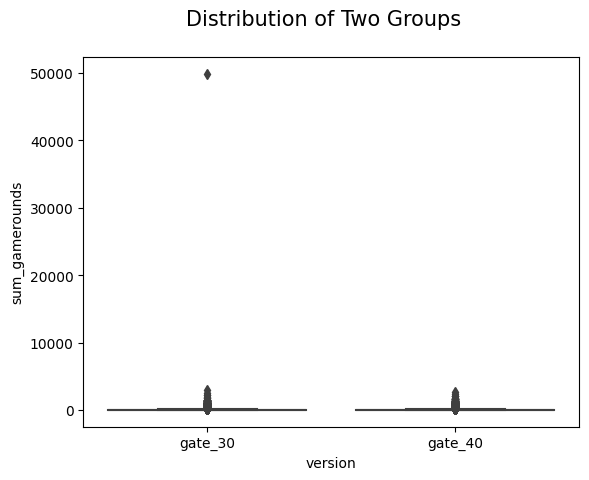

In [8]:
variable = ['sum_gamerounds']
for x in variable:
    print(colored("Summary Statistics by Version for "+x,"cyan", attrs=["bold"]),"\n")
    result = df.groupby("version")[x].aggregate(["count","mean","std","median","min",max])
    result1 = result.transpose()
    print(x)
    print(result1,"\n")
    print(colored("Histogram by Version for "+x,"cyan", attrs=["bold"]),"\n")
    #sns.displot(Data, x=x, hue="Group", element="step", kde=True)
    #plt.show()
    sns.distplot( df[(df.version == "gate_30")][x] , color="skyblue", label="Gate30")
    sns.distplot( df[(df.version == "gate_40")][x] , color="red", label="Gate40")
    plt.legend()
    plt.show()

    plt.suptitle("Distribution of Two Groups", fontsize = 15)
    sns.boxplot(x = df.version, y =df.sum_gamerounds)

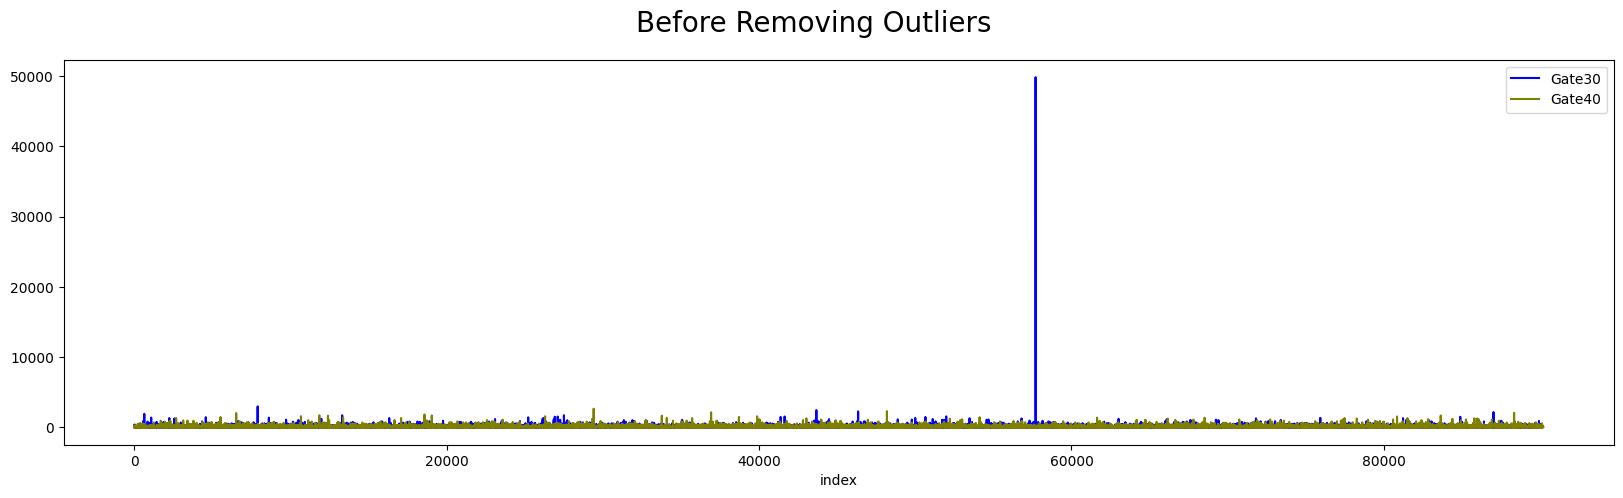

In [9]:
df[df.version == "gate_30"].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate30", figsize = (20,5), color="blue")
df[df.version == "gate_40"].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate40", color="olive")
plt.suptitle("Before Removing Outliers", fontsize = 20);

###Result Handling Outliers

In [10]:
df.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])[["sum_gamerounds"]]

,sum_gamerounds
count,90189.0000
mean,51.8725
std,195.0509
min,0.0000
1%,0.0000
5%,1.0000
10%,1.0000
20%,3.0000
50%,16.0000
80%,67.0000


We can see that the outliers of the data are extreme values, so we will handle the extreme values.

In [11]:
df_clean = df[df.sum_gamerounds < df.sum_gamerounds.max()]

# Summary Stats: sum_gamerounds
df_clean.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])[["sum_gamerounds"]].T

,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,max
sum_gamerounds,90188.0000,51.3203,102.6827,0.0000,0.0000,1.0000,1.0000,3.0000,16.0000,67.0000,134.0000,221.0000,493.0000,2961.0000


In [12]:
df_clean.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])[["sum_gamerounds"]]

,sum_gamerounds
count,90188.0000
mean,51.3203
std,102.6827
min,0.0000
1%,0.0000
5%,1.0000
10%,1.0000
20%,3.0000
50%,16.0000
80%,67.0000


In [13]:
df_clean.describe()

,userid,sum_gamerounds
count,90188.0000,90188.0000
mean,4998396.7979,51.3203
std,2883297.8659,102.6827
min,116.0000,0.0000
25%,2512211.2500,5.0000
50%,4995804.0000,16.0000
75%,7496460.7500,51.0000
max,9999861.0000,2961.0000


Summary Statistics and Visualization (After Removing Outliers)

Summary Statistics by Version for sum_gamerounds 

sum_gamerounds
version    gate_30    gate_40
count   44699.0000 45489.0000
mean       51.3421    51.2988
std       102.0576   103.2944
median     17.0000    16.0000
min         0.0000     0.0000
max      2961.0000  2640.0000 

Histogram by Version for sum_gamerounds 



<ipython-input-14-89fa38e8f201>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df_clean[(df_clean.version == "gate_30")][x] , color="skyblue", label="Gate30")
<ipython-input-14-89fa38e8f201>:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df_clean[(df_clean.version == "gate_40")][x] , col

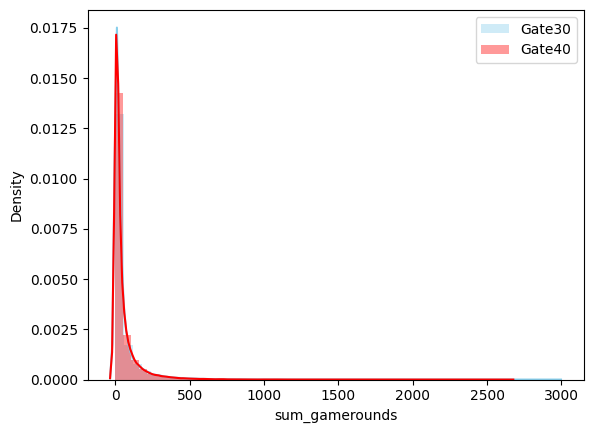

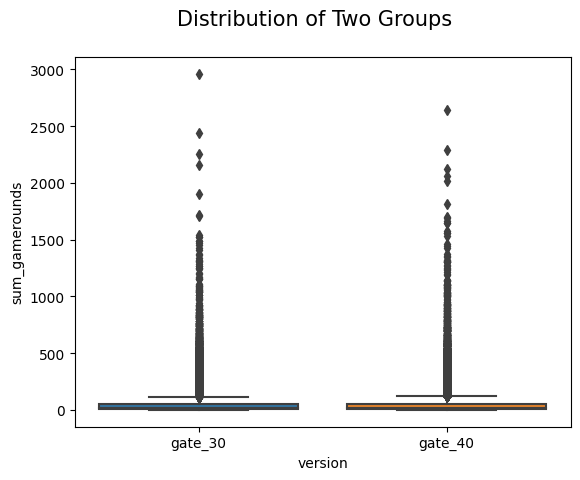

In [14]:
#check whether the outliers are successfully removed or not
variable = ['sum_gamerounds']
for x in variable:
    print(colored("Summary Statistics by Version for "+x,"cyan", attrs=["bold"]),"\n")
    result2 = df_clean.groupby("version")[x].aggregate(["count","mean","std","median","min",max])
    result3 = result2.transpose()
    print(x)
    print(result3,"\n")
    print(colored("Histogram by Version for "+x,"cyan", attrs=["bold"]),"\n")
    #sns.displot(Data, x=x, hue="Group", element="step", kde=True)
    #plt.show()
    sns.distplot( df_clean[(df_clean.version == "gate_30")][x] , color="skyblue", label="Gate30")
    sns.distplot( df_clean[(df_clean.version == "gate_40")][x] , color="red", label="Gate40")
    plt.legend()
    plt.show()

    plt.suptitle("Distribution of Two Groups", fontsize = 15)
    sns.boxplot(x = df_clean.version, y = df_clean.sum_gamerounds)

<ipython-input-15-e2fb144ae575>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_clean[df.version == "gate_30"].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate30", figsize = (20,5), color="blue")
<ipython-input-15-e2fb144ae575>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_clean[df.version == "gate_40"].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate40", color="olive")


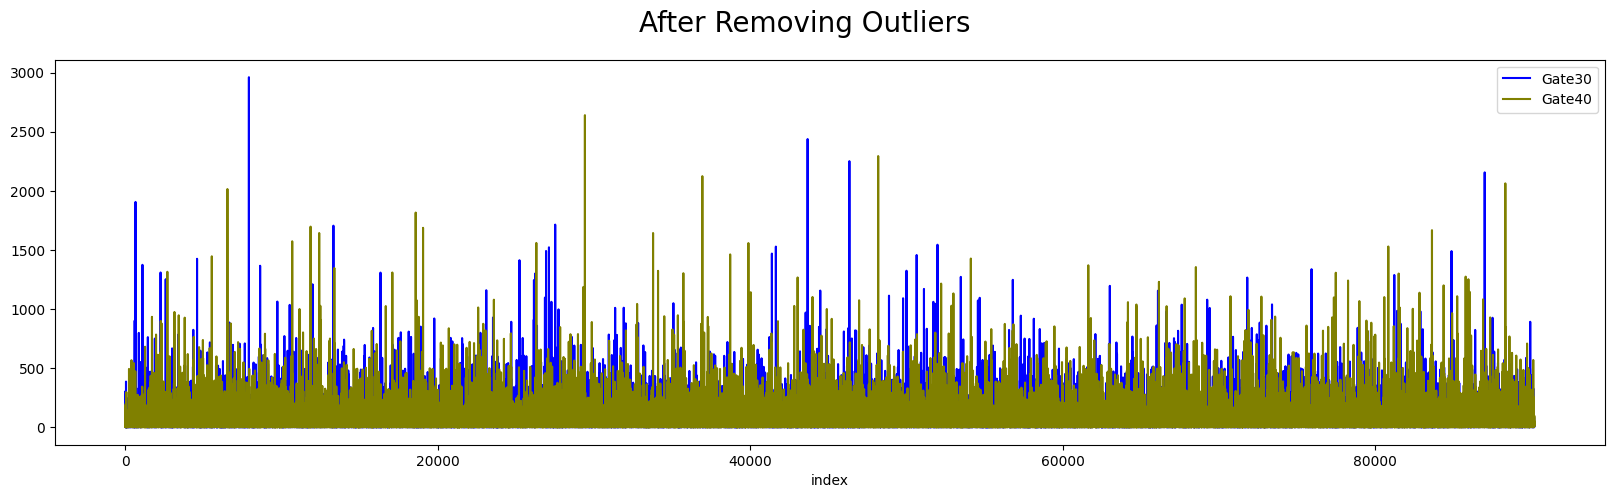

In [15]:
df_clean[df.version == "gate_30"].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate30", figsize = (20,5), color="blue")
df_clean[df.version == "gate_40"].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate40", color="olive")
plt.suptitle("After Removing Outliers", fontsize = 20);

###Formulating hypotheses 

A/B Testing

This section performs A/B testing to compare the means or distributions of the 'sum_gamerounds' variable between the two groups ('gate_30' and 'gate_40'). It follows a step-by-step process:

a. Testing the Normality Assumption

The code checks whether the 'sum_gamerounds' data in each group follows a normal distribution using the Shapiro-Wilk test (shapiro). It prints the test statistics and p-values and provides interpretations based on the results.

b. Testing the Homogeneity Assumption

The homogeneity of variances between the two groups is tested using the Levene's test (stats.levene). The test statistics and p-values are displayed, and interpretations are given based on the results.

c. Alternative 1 - Independent Samples t-Test

If the normality assumption and the homogeneity assumption hold, an independent samples t-test is conducted using the stats.ttest_ind function. The test statistics and p-values are printed, and interpretations are provided based on the results.

d. Alternative 2 - Mann-Whitney U Test

If the normality assumption or the homogeneity assumption is violated, a non-parametric Mann-Whitney U test is performed using the mannwhitneyu function. The U-value and p-value are displayed, and interpretations are given based on the results.

 A/B Testing for sum_gamerounds  

Summary Statistics by Version for sum_gamerounds 

sum_gamerounds
version    gate_30    gate_40
count   44699.0000 45489.0000
mean       51.3421    51.2988
std       102.0576   103.2944
median     17.0000    16.0000
min         0.0000     0.0000
max      2961.0000  2640.0000 

Histogram by Version for sum_gamerounds 



<ipython-input-16-83a24ec702ed>:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df_clean[(df_clean.version == "gate_30")][x] , color="skyblue", label="Gate30")
<ipython-input-16-83a24ec702ed>:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df_clean[(df_clean.version == "gate_40")][x] , col

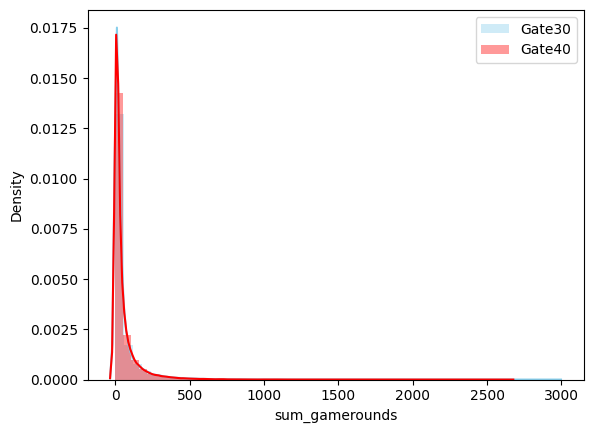

Box Plot by Version for sum_gamerounds 



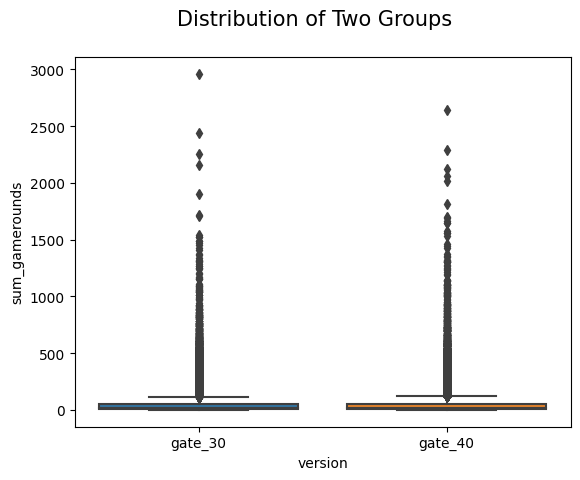

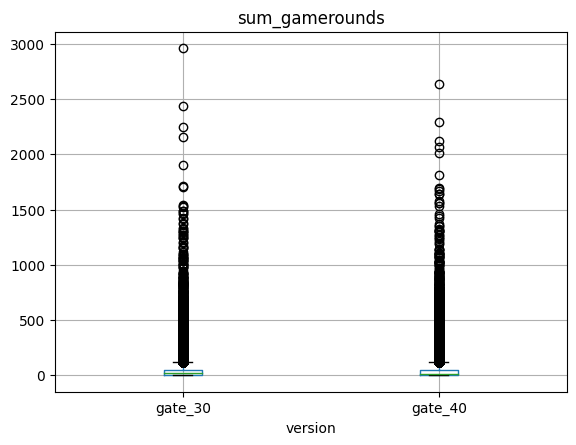

1. Step: Testing the Normality Assumption for sum_gamerounds 

gate_30_shaphiro_p = 0.000, gate_40_shaphiro_p = 0.000 

Shaphiro Wilk Test resulted as p < .05 for gate_30 and gate_40 which indicates that H0 is rejected. Accordingly distribution of sum_gamerounds values in gate_30 and gate_40 are not likely to normal distribution. 

3. Step: Alternative 2 -> Mann-Whitney U Test for sum_gamerounds 

u_value=1024285761.500, mannw_test_p=0.051 

Mann Whitney U Test resulted as p > .05 which indicates that H0 failed to reject. Accordingly there is no significant difference between gate_30 and gate_40 in distributions of sum_gamerounds values. 



/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [16]:
variable = ["sum_gamerounds"]

for x in variable:
    print(colored(" A/B Testing for ","cyan", attrs=["bold",'reverse', 'blink'])+colored(x+" ","cyan", attrs=["bold",'reverse', 'blink']),"\n")
    print(colored("Summary Statistics by Version for "+x,"cyan", attrs=["bold"]),"\n")
    result2 = df_clean.groupby("version")[x].aggregate(["count","mean","std","median","min",max])
    result3 = result2.transpose()
    print(x)
    print(result3,"\n")
    print(colored("Histogram by Version for "+x,"cyan", attrs=["bold"]),"\n")
    #sns.displot(Data, x=x, hue="Group", element="step", kde=True)
    #plt.show()
    sns.distplot( df_clean[(df_clean.version == "gate_30")][x] , color="skyblue", label="Gate30")
    sns.distplot( df_clean[(df_clean.version == "gate_40")][x] , color="red", label="Gate40")
    plt.legend()
    plt.show()

    plt.suptitle("Distribution of Two Groups", fontsize = 15)
    sns.boxplot(x = df_clean.version, y =df_clean.sum_gamerounds)

    def normald():
              
        df_clean.boxplot(column=[x], by="version",return_type=None)
        plt.suptitle("")
        print(colored("Box Plot by Version for "+x,"cyan", attrs=["bold"]),"\n")
        plt.show()
        
        print(colored("1. Step: Testing the Normality Assumption for "+x,"cyan", attrs=["bold"]),"\n")
        gate_30_shaphiro_w, gate_30_shaphiro_p = shapiro(df_clean[(df_clean.version == "gate_30")][x])
        gate_40_shaphiro_w, gate_40_shaphiro_p = shapiro(df_clean[(df_clean.version == "gate_40")][x])
        print("gate_30_shaphiro_p = %.3f, gate_40_shaphiro_p = %.3f" % (gate_30_shaphiro_p, gate_40_shaphiro_p),"\n")
    
        if gate_30_shaphiro_p > 0.05 and gate_40_shaphiro_p > 0.05: 
            print("Shaphiro Wilk Test resulted as p > .05 for gate_30 and gate_40 which indicates that H0 can NOT be rejected. " 
                  "Accordingly distribution of "+x+" values in"+" gate_30 and gate_40 are likely to normal distribution.","\n")
            return 1
        elif gate_30_shaphiro_p < 0.05 and gate_40_shaphiro_p < 0.05:
            print("Shaphiro Wilk Test resulted as p < .05 for gate_30 and gate_40 which indicates that H0 is rejected. " 
                  "Accordingly distribution of "+x+" values in"+" gate_30 and gate_40 are not likely to normal distribution.","\n")
            return 2
        elif gate_30_shaphiro_p > 0.05 and gate_40_shaphiro_p < 0.05:
            print("Pay Attention!: Shaphiro Wilk Test resulted as p > .05 for gate_30 while p < .05 for gate_40 which indicates that H0 is rejected for gate_40. " 
                  "Accordingly you can check if the "+x+" values in"+" gate_40 contain outlier or not","\n")
            return 3
        else :
            print("Pay Attention!: Shaphiro Wilk Test resulted as p > .05 for gate_40 while p < .05 for gate_30 which indicates that H0 is rejected for gate_30. " 
                "Accordingly you can check if the "+x+" values in"+" gate_30 contain outlier or not","\n")
            return 4

    result = normald()
    if result == 1:

            print(colored("2. Step: Testing the Homogeneity Assumption for "+x,"cyan", attrs=["bold"]),"\n")
            levene_F, levene_p = stats.levene(df_clean[(df_clean.version == "gate_30")][x], df_clean[(df_clean.version == "gate_40")][x])
            print("levene_F = %.3f, levene_p = %.3f" % (levene_F, levene_p),"\n")       
            if levene_p > 0.05:
                print("Levene's Test for Homogeneity resulted as p > .05 which indicates that H0 can NOT be rejected."
                      " Accordingly variances of gate_30 and gate_40 are equal.","\n")
                print(colored("3. Step: Alternative 1 -> Independent Samples t Test for "+x,"cyan", attrs=["bold"]),"\n")
                t_value, t_test_p = stats.ttest_ind(df_clean[(df_clean.version == "gate_30")][x], df_clean[(df_clean.version == "gate_40")][x], equal_var=True)
                print("t_value = %.3f, t_test_p = %.3f" % (t_value, t_test_p),"\n")
                if t_test_p > 0.05:
                    print("Independent Samples t Test resulted as p > .05 which indicates that H0 can NOT be rejected."
                          " Accordingly there is no significant difference between gate_30 and gate_40 in "+x+" values.","\n")
                else: 
                    print("Independent Samples t Test resulted as p < .05 which indicates that H0 is rejected."
                          " Accordingly there is a significant difference between gate_30 and gate_40 in "+x+" values.","\n")
                    if statistics.mean(df_clean[(df_clean.version == "gate_30")]) > statistics.mean(df_clean[(df_clean.version == "gate_40")]):
                        print("Mean of gate_30 in "+x+" is greater than gate_40","\n")
                    else:
                        print("Mean of gate_40 in "+x+" is greater than gate_30","\n")
            else : 
                print("Levene's Test for Homogeneity resulted as p < .05 which indicates that H0 is rejected."
                      " Accordingly variances of gate_30 and gate_40 are not equal.","\n")
                print(colored("3. Step: Alternative 1 -> Independent Samples t Test for "+x,"cyan", attrs=["bold"]),"\n")
                t_value, t_test_p = stats.ttest_ind(df_clean[(df_clean.version == "gate_30")][x], df_clean[(df_clean.version == "gate_40")][x], equal_var=False)
                print('t_value = %.3f, t_test_p = %.3f' % (t_value, t_test_p),"\n")
                if t_test_p > 0.05:
                    print("Independent Samples t Test resulted as p > .05 which indicates that H0 can NOT be rejected."
                          " Accordingly there is no significant difference between gate_30 and gate_40 in "+x+" values.","\n")
                else: 
                    print("Independent Samples t Test resulted as p < .05 which indicates that H0 is rejected."
                          " Accordingly there is a significant difference between gate_30 and gate_40 in "+x+" values.","\n")
                    if statistics.mean(df_clean[(df_clean.version == "gate_30")][x]) > statistics.mean(df_clean[(df_clean.version == "gate_40")][x]):
                        print("Mean of gate_30 in "+x+" is greater than gate_40","\n")
                    else:
                        print("Mean of gate_40 in "+x+" is greater than gate_30","\n")
                    
                    
    elif result == 2 or result == 3 or result == 4:
        
            print(colored("3. Step: Alternative 2 -> Mann-Whitney U Test for "+x,"cyan", attrs=["bold"]),"\n")
            u_value, mannw_test_p = mannwhitneyu(df_clean[(df_clean.version == "gate_30")][x], df_clean[(df_clean.version == "gate_40")][x])
            print('u_value=%.3f, mannw_test_p=%.3f' % (u_value, mannw_test_p),"\n")
            if mannw_test_p > 0.05:
                print("Mann Whitney U Test resulted as p > .05 which indicates that H0 failed to reject."
                      " Accordingly there is no significant difference between gate_30 and gate_40 in distributions of "+x+" values.","\n")
            else: 
                print("Mann Whitney U Test resulted as p < .05 which indicates that H0 is rejected."
                      " Accordingly there is a significant difference between gate_30 and gate_40 in distributions of "+x+" values.","\n")
                if statistics.median(df_clean[(df_clean.version == "gate_30")]) > statistics.median(df_clean[(df_clean.version == "gate_40")]):
                    print("Median of gate_30 in "+x+" is greater than gate_40","\n")
                else:
                    print("Median of gate_40 in "+x+" is greater than gate_30","\n")
    else :
            print("Something is wrong. Check your data!")

In [17]:
#See which level is more favorable in terms of player retention
df_clean.groupby("version").retention_1.mean(), df_clean.groupby("version").retention_7.mean()

(version
 gate_30   0.4482
 gate_40   0.4423
 Name: retention_1, dtype: float64,
 version
 gate_30   0.1902
 gate_40   0.1820
 Name: retention_7, dtype: float64)

##Conclusion

There is no significant difference between the two groups regarding moving the first gate from level 30 to level 40 for the game round. If we want to decide based on one metric, both bidding systems can be chosen, but level 30 data shows a lower dev std which can be trusted more.


We can also see which level is more profitable for player retention. Based on the data above, the average retention of 1 day and 7-days is higher when the gate is at level 30 than at level 40. This result follows the first result that level 30 data can be trusted more.
